<a href="https://colab.research.google.com/github/realtommypoole/AAI-511-Team-7-Compo-Identi/blob/tommy-AAI-511/final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ID The Composer Algorithm
##A Deep Learning Neural Network for Composer Identification

###Overview & Goals
This code is designed to ingest music files to train deep learning models in order to identify the composer based on the music alone. The primary objective is to develp a deep learnign model that can predict the composer of a given musical score accurately.

The project aims to accomplish this objective by using two deep learning techniques: Long Short-Term Memory (LSTM) and Convolutional Neural Network (CNN).

This project is part of the Master's In Applied Artificial Intelligence program at the University of San Diego.

###Methodology for this Project
1. Data Collection (data provided via kaggle, workflow via Google Drive)
2. Data Pre-processing: Convert the musical scores into a format suitable for deep learning models. This involves converting the musical scores into MIDI files and applying data augmentation techniques.
3. Feature Extraction: Extract features from the MIDI files, such as notes, chords, and tempo, using music analysis tools.
4. Model Building: Develop a deep learning model using LSTM and CNN architectures to classify the musical scores according to the composer.
5. Model Training: Train the deep learning model using the pre-processed and feature-extracted data.
6. Model Evaluation: Evaluate the performance of the deep learning model using accuracy, precision, and recall metrics.
7. Model Optimization: Optimize the deep learning model by fine-tuning hyperparameters.




#Data Download

In [18]:
# Import Key Libraries
from google.colab import files
import os
import shutil
import ast
import re
import random
import zipfile
from zipfile import ZipFile
import warnings
import pretty_midi
import numpy as np
import pandas as pd
import mido
import seaborn as sns
from tqdm import tqdm
import tensorflow as tf
import pretty_midi as pm
import kagglehub as kagglehub # Wire to kaggle?
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [19]:
#Upload kaggle.json
files.upload()  # Upload your kaggle.json

#Move kaggle.json into the right place and set permission
os.makedirs('/root/.kaggle', exist_ok=True)
shutil.move('kaggle.json', '/root/.kaggle/kaggle.json')
os.chmod('/root/.kaggle/kaggle.json', 0o600)

#Install Kaggle API if not installed
!pip install kaggle

#Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Saving kaggle.json to kaggle.json
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
#Set desired file path
extract_base_dir = '/content/drive/My Drive/ID_Composer_Project/Data'

In [21]:
#Kaggle Data unzip in google drive code, only need to run once
def extract_all_zips(base_dir):
    for root, dirs, files in os.walk(base_dir):
        for file in files:
            if file.lower().endswith('.zip'):
                nested_zip_path = os.path.join(root, file)
                extract_path = os.path.splitext(nested_zip_path)[0]

                print(f"Extracting {nested_zip_path} to {extract_path}")
                try:
                    with zipfile.ZipFile(nested_zip_path, 'r') as zip_ref:
                        zip_ref.extractall(extract_path)
                except zipfile.BadZipFile:
                    print(f"[WARNING] Bad zip file skipped: {nested_zip_path}")
                    continue
                except Exception as e:
                    print(f"[ERROR] Failed to extract {nested_zip_path}: {e}")
                    continue

                # Recursively extract ZIPs inside the new extraction folder
                extract_all_zips(extract_path)

In [23]:
os.makedirs(extract_base_dir, exist_ok=True)

zip_filename = "midi-classic-music.zip"  # expected ZIP filename
zip_path = os.path.join(extract_base_dir, zip_filename)

# Only download if the ZIP file doesn't already exist
if not os.path.exists(zip_path):
    print(f"Downloading dataset to {extract_base_dir}...")
    !kaggle datasets download -d blanderbuss/midi-classic-music -p "{extract_base_dir}"
else:
    print(f"Dataset ZIP already exists at {zip_path}, skipping download.")

# Extract main ZIP if NOT already extracted
extract_dir_check = os.path.splitext(zip_path)[0]
if not os.path.exists(extract_dir_check):
    print(f"Extracting main ZIP file {zip_path} to {extract_base_dir}...") #Optional to print every main zip file
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_base_dir)
else:
    print(f"Main ZIP already extracted to {extract_dir_check}, skipping extraction.")

# Recursively extract any nested ZIP files
extract_all_zips(extract_base_dir)

print("Download and extraction complete.")

Dataset ZIP already exists at /content/drive/My Drive/ID_Composer_Project/Data/midi-classic-music.zip, skipping download.
Extracting main ZIP file /content/drive/My Drive/ID_Composer_Project/Data/midi-classic-music.zip to /content/drive/My Drive/ID_Composer_Project/Data...
Extracting /content/drive/My Drive/ID_Composer_Project/Data/midi-classic-music.zip to /content/drive/My Drive/ID_Composer_Project/Data/midi-classic-music
Extracting /content/drive/My Drive/ID_Composer_Project/Data/midi-classic-music/midiclassics.zip to /content/drive/My Drive/ID_Composer_Project/Data/midi-classic-music/midiclassics
Extracting /content/drive/My Drive/ID_Composer_Project/Data/midi-classic-music/midiclassics/Beethoven/Complete Sonata in A flat major Op.110.zip to /content/drive/My Drive/ID_Composer_Project/Data/midi-classic-music/midiclassics/Beethoven/Complete Sonata in A flat major Op.110
Extracting /content/drive/My Drive/ID_Composer_Project/Data/midi-classic-music/midiclassics/Beethoven/Complete Tem

##Data Pre-Processing

In [24]:
!pip install pretty_midi
#!pip install kagglehub

In [25]:
#Can start here once files have been unzipped into Google Drive
base_dir = extract_base_dir
composers = ['Bach', 'Beethoven', 'Chopin', 'Mozart']

# Store results
matched_paths = []

for root, dirs, files in os.walk(base_dir):
    for f in files:
        file_path = os.path.join(root, f)
        # Check if any composer is in the file path
        if any(composer.lower() in file_path.lower() for composer in composers):
            matched_paths.append(file_path)

# Create DataFrame
df = pd.DataFrame(matched_paths, columns=['filepath'])
pd.set_option('display.max_colwidth', None)  #Show columns as wide as needed
print(df)

                                                                                                                            filepath
0                                           /content/drive/My Drive/ID_Composer_Project/Data/midiclassics/C.P.E.Bach Solfeggieto.mid
1                                 /content/drive/My Drive/ID_Composer_Project/Data/midiclassics/Liszt Bach Prelude Transcription.mid
2                                                    /content/drive/My Drive/ID_Composer_Project/Data/midiclassics/Bach/AveMaria.mid
3                                   /content/drive/My Drive/ID_Composer_Project/Data/midiclassics/Bach/Bwv0525 Sonate en trio n1.mid
4                                   /content/drive/My Drive/ID_Composer_Project/Data/midiclassics/Bach/Bwv0526 Sonate en trio n2.mid
...                                                                                                                              ...
3343    /content/drive/My Drive/ID_Composer_Project/Data/midi-classic

In [9]:
def get_composer_midis(base_dir, composers, supported_ext=('.mid', '.midi')):
    """
    Finds MIDI file paths for selected composers in base_dir and returns a DataFrame and a dict mapping composers to their files.

    Args:
        base_dir (str): Path to search.
        composers (list): List of composer names (strings).
        supported_ext (tuple): Tuple of allowed file extensions.

    Returns:
        df (pd.DataFrame): DataFrame of matching files and composers.
        composer_files (dict): Dict of composer name to list of filepaths.
    """
    matched_paths = []

    for root, dirs, files in os.walk(base_dir):
        for f in files:
            file_path = os.path.join(root, f)
            if file_path.lower().endswith(supported_ext):
                for composer in composers:
                    if composer.lower() in file_path.lower():
                        matched_paths.append({'filepath': file_path, 'composer': composer})
                        break  # Only assign first matching composer

    # Create DataFrame
    df = pd.DataFrame(matched_paths)
    pd.set_option('display.max_colwidth', None)

    # Drop any rows where composer is not found (shouldn't happen here, but kept for safety)
    df = df.dropna(subset=['composer'])

    # Collect filepaths for each composer
    composer_files = {composer: df[df['composer'] == composer]['filepath'].tolist() for composer in composers}

    # Print stats
    for composer, files in composer_files.items():
        print(f"{composer}: {len(files)} files")

    return df, composer_files

In [10]:
#Usage Example
base_dir = extract_base_dir
composers = ['Bach', 'Beethoven', 'Chopin', 'Mozart']

df, composer_files = get_composer_midis(base_dir, composers)
print(df)

Bach: 2100 files
Beethoven: 440 files
Chopin: 276 files
Mozart: 518 files
                                                                                                                                       filepath  \
0                          /content/drive/My Drive/AAI-511-Team7ProjectFolder/Composer_Data_2/midiclassics/Liszt Bach Prelude Transcription.mid   
1                                    /content/drive/My Drive/AAI-511-Team7ProjectFolder/Composer_Data_2/midiclassics/C.P.E.Bach Solfeggieto.mid   
2                            /content/drive/My Drive/AAI-511-Team7ProjectFolder/Composer_Data_2/midiclassics/Bach/Bwv0525 Sonate en trio n1.mid   
3     /content/drive/My Drive/AAI-511-Team7ProjectFolder/Composer_Data_2/midiclassics/Bach/Piano version of Bachs two part inventions No.12.mid   
4        /content/drive/My Drive/AAI-511-Team7ProjectFolder/Composer_Data_2/midiclassics/Bach/Bwv0558 Short Prelude and Fugue n6 (Spurious).mid   
...                                         

In [11]:
#Confirm df set up
df.head()

,filepath,composer
0,/content/drive/My Drive/AAI-511-Team7ProjectFolder/Composer_Data_2/midiclassics/Liszt Bach Prelude Transcription.mid,Bach
1,/content/drive/My Drive/AAI-511-Team7ProjectFolder/Composer_Data_2/midiclassics/C.P.E.Bach Solfeggieto.mid,Bach
2,/content/drive/My Drive/AAI-511-Team7ProjectFolder/Composer_Data_2/midiclassics/Bach/Bwv0525 Sonate en trio n1.mid,Bach
3,/content/drive/My Drive/AAI-511-Team7ProjectFolder/Composer_Data_2/midiclassics/Bach/Piano version of Bachs two part inventions No.12.mid,Bach
4,/content/drive/My Drive/AAI-511-Team7ProjectFolder/Composer_Data_2/midiclassics/Bach/Bwv0558 Short Prelude and Fugue n6 (Spurious).mid,Bach


#Data Pre-Processing & Feature Extraction

In [12]:
#Set universal random seed for codeset
SEED = 42

def set_random_seed(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

set_random_seed(SEED)

In [13]:
#Try to maintain as much data as possible, but balance datasets by downsampling Bach
bach_name = 'Bach' # List composer names for safety

df_bach     = df[df['composer'] == bach_name].sample(frac=0.6, random_state=SEED)
df_others   = df[df['composer'] != bach_name].groupby('composer', group_keys=False).sample(frac=1, random_state=SEED)

# Combine and shuffle (optional)
df_sampled = pd.concat([df_bach, df_others]).reset_index(drop=True)
df_sampled = df_sampled.sample(frac=1.0, random_state=SEED).reset_index(drop=True)  # optional: shuffle

df = df_sampled

# Confirm total number of filepaths
print(len(df))

2494


In [14]:
#Sanatize MIDI files to remove problematic files
def sanitize_midi(input_path, output_path=None):
    try:
        mid = mido.MidiFile(input_path)
        global_events = []
        new_tracks = [mido.MidiTrack()]
        for i, track in enumerate(mid.tracks):
            new_track = mido.MidiTrack()
            for msg in track:
                if msg.is_meta and msg.type in ['set_tempo', 'key_signature', 'time_signature']:
                    if i != 0:  # Only move if not already in track 0
                        global_events.append(msg)
                    else:
                        new_track.append(msg)
                else:
                    new_track.append(msg)
            if i != 0:
                new_tracks.append(new_track)
        new_tracks[0].extend(global_events)
        mid.tracks = new_tracks
        output = output_path or input_path
        mid.save(output)
    except Exception as e:
        if 'KeySignatureError' in str(e) or 'Could not decode key' in str(e):
            print(f"[SKIP] {input_path}: {e}")
        else:
            print(f"[ERROR] {input_path}: {e}")
        raise #Ensure calling code also sees error for handling

In [15]:
successful_paths = []
failed_paths = []

for path in tqdm(df['filepath'], desc="Sanitizing MIDI files"):
    try:
        sanitize_midi(path)
        successful_paths.append(path)  # Only add if sanitize did NOT raise an exception
    except Exception as e:
        failed_paths.append(path)      # Log failures for later inspection
        tqdm.write(f"[SKIP/ERROR] {path}: {e}")

Sanitizing MIDI files:  15%|█▍        | 370/2494 [01:36<08:31,  4.15it/s]

[ERROR] /content/drive/My Drive/AAI-511-Team7ProjectFolder/Composer_Data_2/archive/midiclassics/Varios - Ti'tulo desconocido/a_h/chopin7.mid: MThd not found. Probably not a MIDI file
[SKIP/ERROR] /content/drive/My Drive/AAI-511-Team7ProjectFolder/Composer_Data_2/archive/midiclassics/Varios - Ti'tulo desconocido/a_h/chopin7.mid: MThd not found. Probably not a MIDI file


Sanitizing MIDI files:  52%|█████▏    | 1308/2494 [05:31<04:39,  4.24it/s]

[SKIP] /content/drive/My Drive/AAI-511-Team7ProjectFolder/Composer_Data_2/archive/midiclassics/Beethoven/Anhang 14-3.mid: Could not decode key with 3 flats and mode 255
[SKIP/ERROR] /content/drive/My Drive/AAI-511-Team7ProjectFolder/Composer_Data_2/archive/midiclassics/Beethoven/Anhang 14-3.mid: Could not decode key with 3 flats and mode 255


Sanitizing MIDI files:  60%|██████    | 1505/2494 [06:24<04:05,  4.04it/s]

[SKIP] /content/drive/My Drive/AAI-511-Team7ProjectFolder/Composer_Data_2/midiclassics/Beethoven/Anhang 14-3.mid: Could not decode key with 3 flats and mode 255
[SKIP/ERROR] /content/drive/My Drive/AAI-511-Team7ProjectFolder/Composer_Data_2/midiclassics/Beethoven/Anhang 14-3.mid: Could not decode key with 3 flats and mode 255


Sanitizing MIDI files:  63%|██████▎   | 1572/2494 [06:42<03:28,  4.42it/s]

[ERROR] /content/drive/My Drive/AAI-511-Team7ProjectFolder/Composer_Data_2/midiclassics/Varios - Ti'tulo desconocido/a_h/chopin7.mid: MThd not found. Probably not a MIDI file
[SKIP/ERROR] /content/drive/My Drive/AAI-511-Team7ProjectFolder/Composer_Data_2/midiclassics/Varios - Ti'tulo desconocido/a_h/chopin7.mid: MThd not found. Probably not a MIDI file


Sanitizing MIDI files:  71%|███████   | 1776/2494 [07:35<03:16,  3.65it/s]

[SKIP] /content/drive/My Drive/AAI-511-Team7ProjectFolder/Composer_Data_2/midiclassics/Mozart/Piano Sonatas/Nueva carpeta/K281 Piano Sonata n03 3mov.mid: Could not decode key with 2 flats and mode 2
[SKIP/ERROR] /content/drive/My Drive/AAI-511-Team7ProjectFolder/Composer_Data_2/midiclassics/Mozart/Piano Sonatas/Nueva carpeta/K281 Piano Sonata n03 3mov.mid: Could not decode key with 2 flats and mode 2


Sanitizing MIDI files:  72%|███████▏  | 1804/2494 [07:44<03:08,  3.65it/s]

[SKIP] /content/drive/My Drive/AAI-511-Team7ProjectFolder/Composer_Data_2/archive/midiclassics/Mozart/Piano Sonatas/Nueva carpeta/K281 Piano Sonata n03 3mov.mid: Could not decode key with 2 flats and mode 2
[SKIP/ERROR] /content/drive/My Drive/AAI-511-Team7ProjectFolder/Composer_Data_2/archive/midiclassics/Mozart/Piano Sonatas/Nueva carpeta/K281 Piano Sonata n03 3mov.mid: Could not decode key with 2 flats and mode 2


Sanitizing MIDI files: 100%|██████████| 2494/2494 [10:39<00:00,  3.90it/s]


In [16]:
#Print length of successful and failed files
print("Total df before sanitation:", len(df))
print("Successful files:", len(successful_paths))
print("Failed files:", len(failed_paths))

Total df before sanitation: 2494
Successful files: 2488
Failed files: 6


In [17]:
#Update df with successful_paths
df = df[df['filepath'].isin(successful_paths)]

#Print length of df to confirm
print(len(df))

2488


In [18]:
# Define function to extract statistical features from MIDI files
def compute_statistical_midi_features(midi_file_path):
    """
    Extracts statistical features from a MIDI file for composer classification.
    These features represent the style, complexity, and structure of the music,
    and are used in classical ML models (RandomForest, XGBoost) for prediction.
    """

    # Load the MIDI file using PrettyMIDI for feature extraction
    midi_obj = pm.PrettyMIDI(midi_file_path)

    # Extract all note events from non-drum instruments (focus on melodic/harmonic elements)
    note_list = [note for instr in midi_obj.instruments if not instr.is_drum for note in instr.notes]

    # Sort notes by their start time to compute inter-onset intervals (IOI) correctly
    note_list.sort(key=lambda n: n.start)

    # Extract pitches from notes (MIDI note numbers, e.g., 60 = Middle C)
    pitch_values = [note.pitch for note in note_list]

    # Extract note durations (end time - start time) to analyze rhythm patterns
    duration_values = [note.end - note.start for note in note_list]

    # Extract velocities (note intensity, related to loudness or emphasis)
    velocity_values = [note.velocity for note in note_list]

    # Compute inter-onset intervals (IOI): time difference between consecutive note starts
    iois = [note_list[i].start - note_list[i-1].start for i in range(1, len(note_list))]

    # Extract tempo (beats per minute). Use first tempo value or default to 120 BPM if missing.
    tempo_changes = midi_obj.get_tempo_changes()[1]
    tempo_value = tempo_changes[0] if tempo_changes.size else 120

    # Safely extract key signature (e.g., number of sharps/flats) or None if unavailable
    try:
        key_signature = midi_obj.key_signature_changes[0].key_number if midi_obj.key_signature_changes else None
    except Exception:
        key_signature = None

    # Safely extract time signature (e.g., 4/4, 3/4). Return None if not found.
    try:
        time_sig_obj = midi_obj.time_signature_changes[0] if midi_obj.time_signature_changes else None
        time_signature = f"{time_sig_obj.numerator}/{time_sig_obj.denominator}" if time_sig_obj else None
    except Exception:
        time_signature = None

    # Return all extracted features in a dictionary for use in ML models
    return {
        # Total duration of the MIDI piece in seconds
        # Useful to capture overall length and pacing (some composers write longer pieces)
        "total_duration": midi_obj.get_end_time(),

        # Number of instruments used (polyphonic richness can differ by composer)
        "instrument_count": len(midi_obj.instruments),

        # Total number of notes in the piece (measures overall activity and complexity)
        "total_notes": len(pitch_values),

        # Note density: number of notes per second (captures speed & ornamentation style)
        "note_density": len(pitch_values) / midi_obj.get_end_time() if midi_obj.get_end_time() > 0 else None,

        # Average velocity of notes (represents expressive dynamics; some composers write more nuanced dynamics)
        "velocity_mean": np.mean(velocity_values) if velocity_values else None,

        # Minimum pitch (lowest note). Can reveal usage of bass notes or registers.
        "min_pitch": min(pitch_values) if pitch_values else None,

        # Maximum pitch (highest note). Useful for range analysis between composers.
        "max_pitch": max(pitch_values) if pitch_values else None,

        # Average pitch (overall register of the piece; e.g., Chopin uses higher average pitch in solos)
        "avg_pitch": np.mean(pitch_values) if pitch_values else None,

        # Most frequently occurring pitch (mode of pitch distribution; shows melodic patterns or drones)
        "common_pitch": max(set(pitch_values), key=pitch_values.count) if pitch_values else None,

        # Mean note duration (longer notes imply slower melodies, shorter = faster ornamentation)
        "mean_duration": np.mean(duration_values) if duration_values else None,

        # Standard deviation of note durations (measures rhythmic variation or stability)
        "std_duration": np.std(duration_values) if len(duration_values) > 1 else 0,

        # Mean inter-onset interval (average time gap between notes; relates to tempo feel and spacing)
        "mean_ioi": np.mean(iois) if iois else None,

        # Std deviation of IOI (rhythmic complexity: stable rhythm vs expressive rubato)
        "std_ioi": np.std(iois) if iois else None,

        # Tempo in BPM (can reflect stylistic differences in tempo choices)
        "tempo": tempo_value,

        # Key signature (numeric representation; important for harmonic profiling)
        "key_signature": key_signature,

        # Time signature (e.g., 4/4, 3/4; rhythmic structure of the piece)
        "time_signature": time_signature
    }

In [19]:
# Define function to compute sequential features from MIDI files
def compute_sequence_midi_features(midi_file_path, max_length=5000):
    """
    Extracts sequence-based features from a MIDI file for deep learning models (LSTM/CNN).
    These features capture temporal, harmonic, and rhythmic information critical for composer classification.
    """

    # Load the MIDI file using PrettyMIDI for sequence extraction
    midi_obj = pm.PrettyMIDI(midi_file_path)

    # Extract all non-drum notes from all instruments to focus on melody/harmony
    # Drums are excluded because they don't carry pitch information
    notes = sorted([n for i in midi_obj.instruments if not i.is_drum for n in i.notes], key=lambda n: n.start)

    # Create note sequence matrix with columns:
    # [start_time, pitch, duration, velocity]
    # This sequence preserves the order of musical events.
    # Useful for LSTM/RNN models that require sequential data inputs.
    note_sequence_matrix = np.array([[n.start, n.pitch, n.end - n.start, n.velocity] for n in notes])

    # Extract piano roll matrix (shape: 128 pitches x time frames)
    # Each cell represents note intensity at a given pitch and time
    # Used as input for CNNs treating the piano roll as an image
    piano_roll_matrix = midi_obj.get_piano_roll(fs=50)

    # Pad or crop the piano roll to a consistent length (max_length = 5000 frames)
    # Padding ensures all sequences are the same length, required for CNN input
    piano_roll_matrix = np.pad(piano_roll_matrix, ((0, 0), (0, max(0, max_length - piano_roll_matrix.shape[1]))))[:, :max_length]

    # Extract chroma matrix (12 pitch classes x time frames)
    # Summarizes notes into octave-invariant pitch classes (C, C#, D, ..., B)
    # Captures harmonic information useful for composer style analysis
    chroma_matrix = midi_obj.get_chroma(fs=50)

    # Pad or crop chroma matrix to max_length to ensure consistent input size
    chroma_matrix = np.pad(chroma_matrix, ((0, 0), (0, max(0, max_length - chroma_matrix.shape[1]))))[:, :max_length]

    # Initialize onset matrix (same shape as piano roll)
    # This represents note onsets specifically (when each note starts)
    onset_matrix = np.zeros_like(piano_roll_matrix)

    # Populate the onset matrix: set velocity at the note's starting time index
    # This feature captures temporal structure and is important for rhythm modeling
    for n in notes:
        idx = int(n.start * 50)  # Convert start time to frame index based on 50 Hz resolution
        if idx < max_length:
            onset_matrix[n.pitch, idx] = n.velocity

    # Compute rhythm array: a 1D binary array indicating whether any note starts at each time step
    # Summarizing onset events across all pitches into a single rhythm vector
    # Useful for capturing global rhythmic patterns irrespective of pitch
    rhythm_array = (np.sum(onset_matrix, axis=0, keepdims=True) > 0).astype(int)

    # Return the extracted sequence-based features as a dictionary
    return {
        # The raw sequence of musical notes, useful for LSTM input
        "note_seq": note_sequence_matrix,

        # The piano roll image-like matrix, used for CNN-based classification
        "piano_roll": piano_roll_matrix,

        # Chroma feature matrix (12 pitch classes), useful for tonal/harmonic analysis
        "chroma": chroma_matrix,

        # Onset matrix indicating exactly when each note starts
        "onset_pattern": onset_matrix,

        # Rhythm pattern (1D), capturing time steps where any note starts
        "rhythm_pattern": rhythm_array
    }

#New approach?

In [ ]:
# ----------------------------------------
# Step 2: MIDI Statistics Extraction
# ----------------------------------------
def extract_note_statistics(file_path):
    midi_data = pretty_midi.PrettyMIDI(file_path)
    pitches = [note.pitch for instr in midi_data.instruments for note in instr.notes]
    velocities = [note.velocity for instr in midi_data.instruments for note in instr.notes]
    _, tempos = midi_data.get_tempo_changes()

    return {
        'pitch_std': np.std(pitches),
        'pitch_min': np.min(pitches),
        'pitch_max': np.max(pitches),
        'velocity_mean': np.mean(velocities),
        'velocity_std': np.std(velocities),
        'velocity_min': np.min(velocities),
        'velocity_max': np.max(velocities),
        'tempo_mean': np.mean(tempos),
        'tempo_min': np.min(tempos),
        'tempo_max': np.max(tempos),
    }

In [ ]:
def extract_statistics_dataframe(df):
    stats = []
    for _, row in df.iterrows():
        try:
            feats = extract_note_statistics(row['filepath'])
            feats['composer'] = row['composer']
            stats.append(feats)
        except Exception as e:
            print(f"Error in stats for {row['filepath']}: {e}")
    return pd.DataFrame(stats)

In [ ]:
# ----------------------------------------
# Step 3: Multichannel Piano Roll
# ----------------------------------------
def process_multichannel_midi(file_path, fs=8, max_length=150):
    midi = pretty_midi.PrettyMIDI(file_path)
    piano_roll = midi.get_piano_roll(fs=fs)
    binary_roll = (piano_roll > 0).astype(np.float32)
    velocity_roll = (piano_roll / 127.0).astype(np.float32)

    instrument_rolls = [instr.get_piano_roll(fs=fs) for instr in midi.instruments]
    max_len = max((r.shape[1] for r in instrument_rolls), default=0)
    inst_combined = np.zeros((128, max_len))
    for roll in instrument_rolls:
        roll = np.pad(roll, ((0, 0), (0, max_len - roll.shape[1])), mode='constant')
        inst_combined += (roll > 0).astype(np.float32)
    inst_combined = (inst_combined / inst_combined.max()).astype(np.float32) if inst_combined.max() > 0 else inst_combined

    expressive_roll = np.zeros((128, max_len))
    for instr in midi.instruments:
        for note in instr.notes:
            start = int(note.start * fs)
            end = int(note.end * fs)
            expressive_roll[note.pitch, start:end] = 1
    expressive_roll = expressive_roll.astype(np.float32)

    def fix_length(arr): return np.pad(arr, ((0, 0), (0, max(0, max_length - arr.shape[1]))), mode='constant')[:, :max_length]
    binary_roll = fix_length(binary_roll)
    velocity_roll = fix_length(velocity_roll)
    inst_combined = fix_length(inst_combined)
    expressive_roll = fix_length(expressive_roll)

    return np.stack([binary_roll, velocity_roll, inst_combined, expressive_roll], axis=-1)

In [ ]:
# ----------------------------------------
# Step 4: Dataset Creation
# ----------------------------------------
def create_combined_dataset(df, fs=8, max_length=150):
    X_roll, X_stats, y = [], [], []
    label_map = {name: idx for idx, name in enumerate(COMPOSERS)}
    for _, row in df.iterrows():
        try:
            roll = process_multichannel_midi(row['filepath'], fs=fs, max_length=max_length)
            stats = extract_note_statistics(row['filepath'])
            X_roll.append(roll)
            X_stats.append(list(stats.values()))
            y.append(label_map[row['composer']])
        except Exception as e:
            print(f"Error processing {row['filepath']}: {e}")
    return (np.array(X_roll).astype(np.float32),
            np.array(X_stats).astype(np.float32),
            to_categorical(np.array(y), num_classes=len(COMPOSERS)))

#End New Approach

In [20]:
#Set persistent base directory in your Drive
os.makedirs(base_dir, exist_ok=True)

# SV for extracted features
csv_path = os.path.join(base_dir, 'features_partial.csv')

#Dedicated directory for array storage
ARRAY_SAVE_DIR = os.path.join(base_dir, 'saved_arrays')
os.makedirs(ARRAY_SAVE_DIR, exist_ok=True)

In [21]:
#Clear previous CSV if starting over
if os.path.exists(csv_path):
    os.remove(csv_path)

In [22]:
results = []

for idx, row in tqdm(df.iterrows(), total=len(df), desc="Extracting features"):
    midi_file = row['filepath']
    composer_label = row['composer']
    try:
        stat_features = compute_statistical_midi_features(midi_file)
        seq_features = compute_sequence_midi_features(midi_file)

        # Save note_seq array as .npy and store its path
        note_seq = seq_features.get('note_seq')
        note_seq_path = None
        if isinstance(note_seq, np.ndarray):
            array_filename = f"{os.path.splitext(os.path.basename(midi_file))[0]}_note_seq_{idx}.npy"
            array_filepath = os.path.join(ARRAY_SAVE_DIR, array_filename)
            np.save(array_filepath, note_seq)
            note_seq_path = array_filepath
            del seq_features['note_seq']

        combined = {
            **stat_features,
            **seq_features,
            "note_seq_path": note_seq_path,
            "composer": composer_label,
            "file": midi_file,
        }
        results.append(combined)

        # Flush every 100 files
        if len(results) % 100 == 0:
            pd.DataFrame(results).to_csv(
                csv_path,
                mode='a',
                header=not os.path.exists(csv_path),
                index=False
            )
            results = []

    except Exception as e:
        print(f"[ERROR] Failed to process {midi_file}: {e}")

# Save remaining results
if results:
    pd.DataFrame(results).to_csv(
        csv_path,
        mode='a',
        header=not os.path.exists(csv_path),
        index=False
    )

Extracting features: 100%|██████████| 2488/2488 [10:07<00:00,  4.09it/s]


In [23]:
features_df = pd.read_csv(csv_path) #From GoogleDrive
df_copy = features_df.copy()
#features_df = df_copy.copy() #For troubleshooting purposes
print(features_df.columns)

Index(['total_duration', 'instrument_count', 'total_notes', 'note_density',
       'velocity_mean', 'min_pitch', 'max_pitch', 'avg_pitch', 'common_pitch',
       'mean_duration', 'std_duration', 'mean_ioi', 'std_ioi', 'tempo',
       'key_signature', 'time_signature', 'piano_roll', 'chroma',
       'onset_pattern', 'rhythm_pattern', 'note_seq_path', 'composer', 'file'],
      dtype='object')


In [24]:
features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2488 entries, 0 to 2487
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   total_duration    2488 non-null   float64
 1   instrument_count  2488 non-null   int64  
 2   total_notes       2488 non-null   int64  
 3   note_density      2434 non-null   float64
 4   velocity_mean     2434 non-null   float64
 5   min_pitch         2434 non-null   float64
 6   max_pitch         2434 non-null   float64
 7   avg_pitch         2434 non-null   float64
 8   common_pitch      2434 non-null   float64
 9   mean_duration     2434 non-null   float64
 10  std_duration      2488 non-null   float64
 11  mean_ioi          2434 non-null   float64
 12  std_ioi           2434 non-null   float64
 13  tempo             2488 non-null   float64
 14  key_signature     0 non-null      float64
 15  time_signature    0 non-null      float64
 16  piano_roll        2488 non-null   object 


In [52]:
# Initialize the 'note_seq' column with None
features_df['note_seq'] = None

# Iterate over rows with valid 'note_seq_path' and load arrays once
for idx, path in features_df['note_seq_path'].dropna().items():
    try:
        features_df.at[idx, 'note_seq'] = np.load(path)
    except Exception as e:
        print(f"Failed to load {path} at index {idx}: {e}")

# Print example loaded array and its type
print(features_df['note_seq'].iloc[0])  # Should print a numpy array
print(type(features_df['note_seq'].iloc[0]))  # Should print <class 'numpy.ndarray'>

[[1.04166667e-03 7.70000000e+01 7.50000000e-01 6.00000000e+01]
 [5.00000000e-01 5.80000000e+01 5.00000000e-01 4.20000000e+01]
 [7.50000000e-01 7.40000000e+01 2.50000000e-01 5.30000000e+01]
 ...
 [4.55500000e+02 7.40000000e+01 2.50000000e-01 8.40000000e+01]
 [4.55500000e+02 4.60000000e+01 2.50000000e-01 8.90000000e+01]
 [4.55500000e+02 3.40000000e+01 2.50000000e-01 7.50000000e+01]]
<class 'numpy.ndarray'>


In [26]:
print(features_df.columns) #Ensure note_seq is added

Index(['total_duration', 'instrument_count', 'total_notes', 'note_density',
       'velocity_mean', 'min_pitch', 'max_pitch', 'avg_pitch', 'common_pitch',
       'mean_duration', 'std_duration', 'mean_ioi', 'std_ioi', 'tempo',
       'key_signature', 'time_signature', 'piano_roll', 'chroma',
       'onset_pattern', 'rhythm_pattern', 'note_seq_path', 'composer', 'file',
       'note_seq'],
      dtype='object')


##Exploratory Data Analysis

In [27]:
def run_exploratory_data_analysis(features_df):
    """
    Performs Exploratory Data Analysis (EDA) including pairplots, boxplots, and heatmaps.
    Focuses only on scalar features for visualization.
    """
    # Print dataset summary statistics
    print("Dataset Overview:\n", features_df.describe())

    # Print missing values in the dataset
    print("\nMissing Data Report:\n", features_df.isnull().sum())

    # Select numeric scalar features for visualization (no sequence arrays)
    scalar_df = features_df[['total_duration', 'total_notes', 'note_density', 'avg_pitch', 'tempo', 'composer']].copy()

    # Pairplot to see pairwise distributions per composer
    sns.pairplot(scalar_df, hue='composer', vars=['total_duration', 'total_notes', 'note_density', 'avg_pitch', 'tempo'])
    plt.show()

    # Boxplot of note density by composer
    plt.figure(figsize=(10,6))
    sns.boxplot(x='composer', y='note_density', data=scalar_df)
    plt.title("Note Density by Composer")
    plt.show()

    # Heatmap of feature correlations
    plt.figure(figsize=(8,6))
    sns.heatmap(scalar_df.drop(columns=['composer']).corr(), annot=True, cmap='coolwarm', fmt=".2f", square=True)

    plt.title("Feature Correlation Heatmap")
    plt.show()

Dataset Overview:
        total_duration  instrument_count   total_notes  note_density  \
count     2488.000000       2488.000000   2488.000000   2434.000000   
mean       236.139335          5.305466   3442.246383     13.259553   
std        290.890635          4.900532   5133.649617      8.041913   
min          0.000000          0.000000      0.000000      2.956724   
25%         41.865649          2.000000    393.000000      8.144584   
50%        119.908333          4.000000   1362.500000     10.833640   
75%        305.400000          6.000000   4438.000000     15.789474   
max       2228.000000         40.000000  46897.000000     69.022285   

       velocity_mean    min_pitch    max_pitch    avg_pitch  common_pitch  \
count    2434.000000  2434.000000  2434.000000  2434.000000   2434.000000   
mean       81.396342    34.511915    85.290879    63.104374     64.570666   
std        18.936234     6.516606     7.411959     3.100938      6.714369   
min        30.812865     9.000000

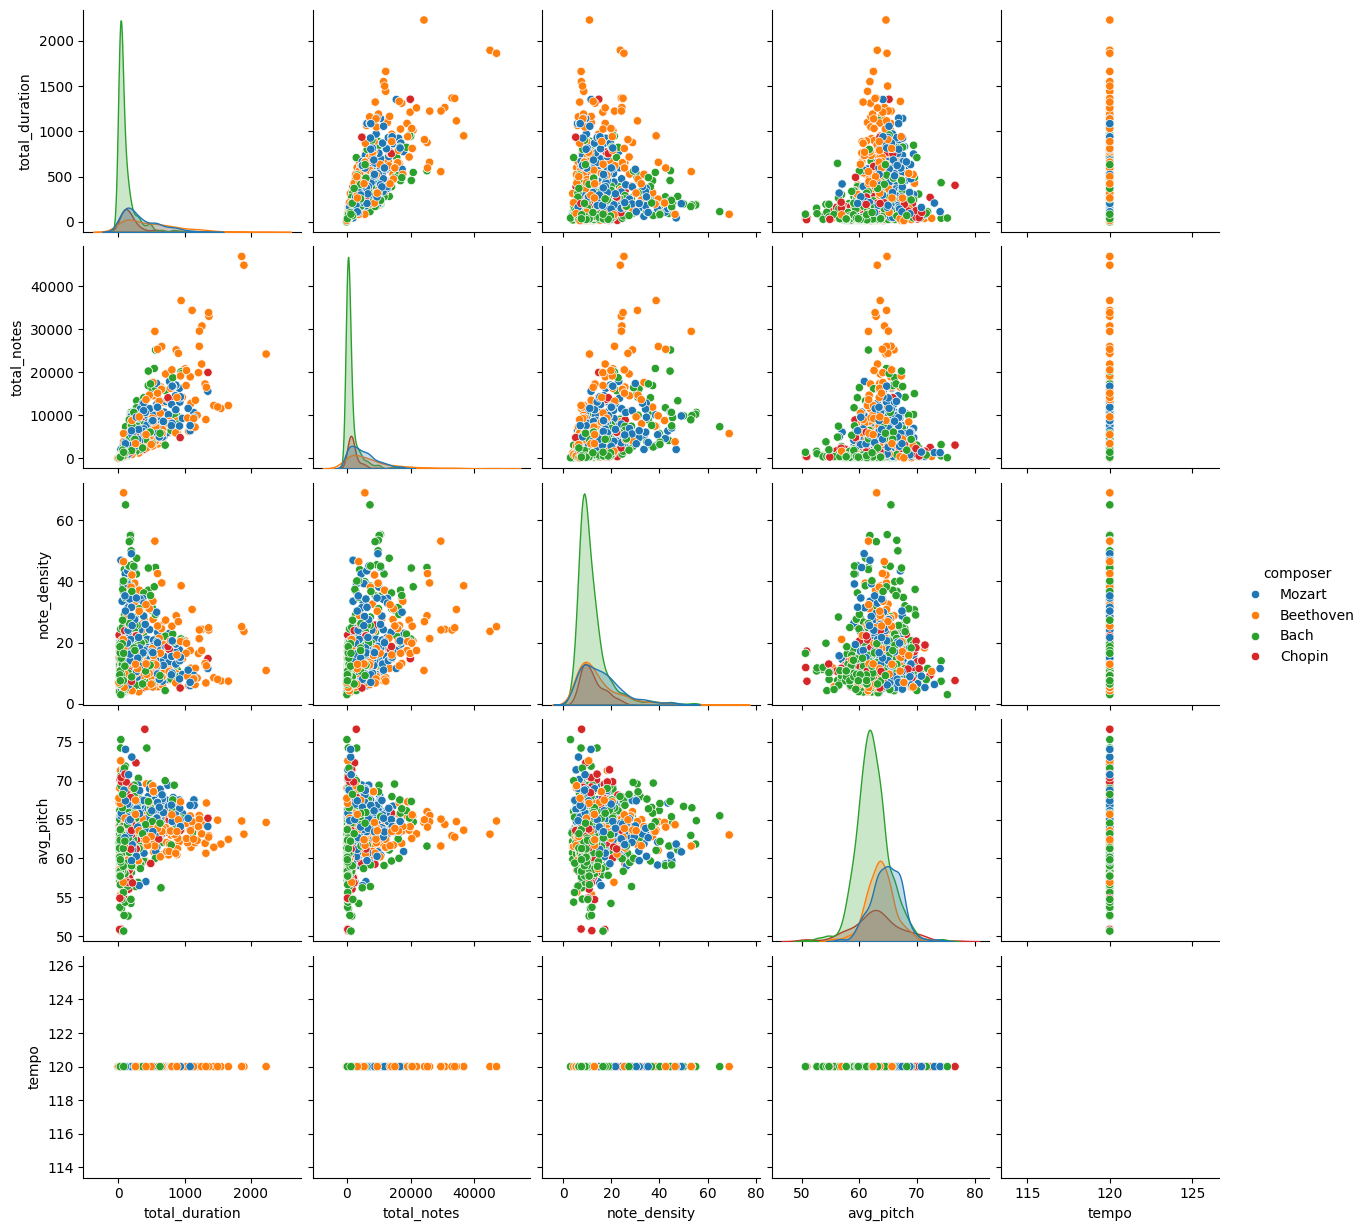

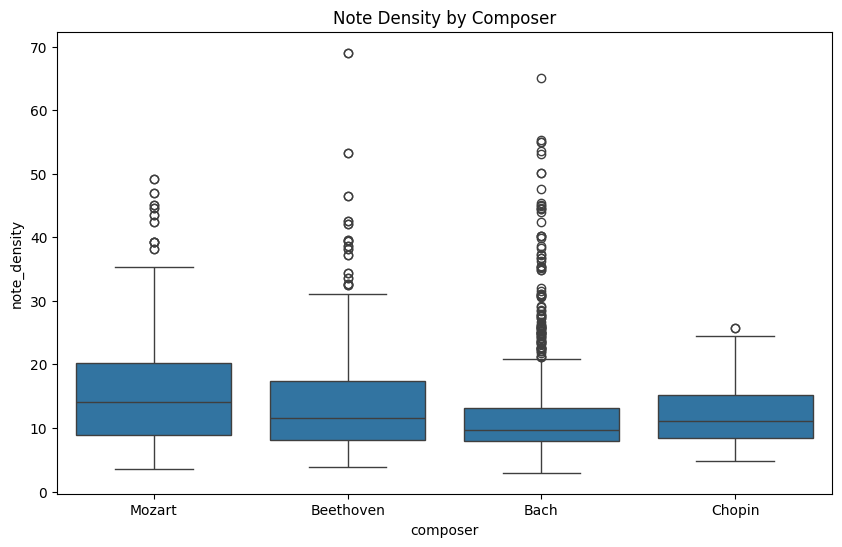

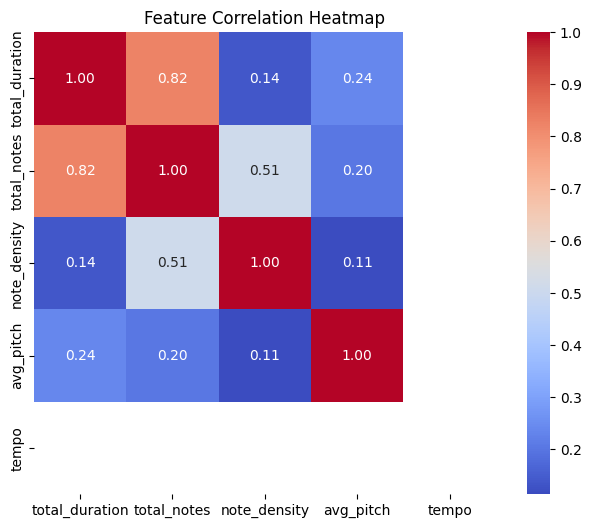

In [28]:
run_exploratory_data_analysis(features_df)

_____
###Explore Note Sequences specifically
These sequential features will be cused for LSTM and CNN analysis.

Number of valid sequences: 2434
Mean sequence length (number of notes): 3518.615036976171
Median sequence length 1424.5
Min sequence length: 83
Max sequence length: 46897


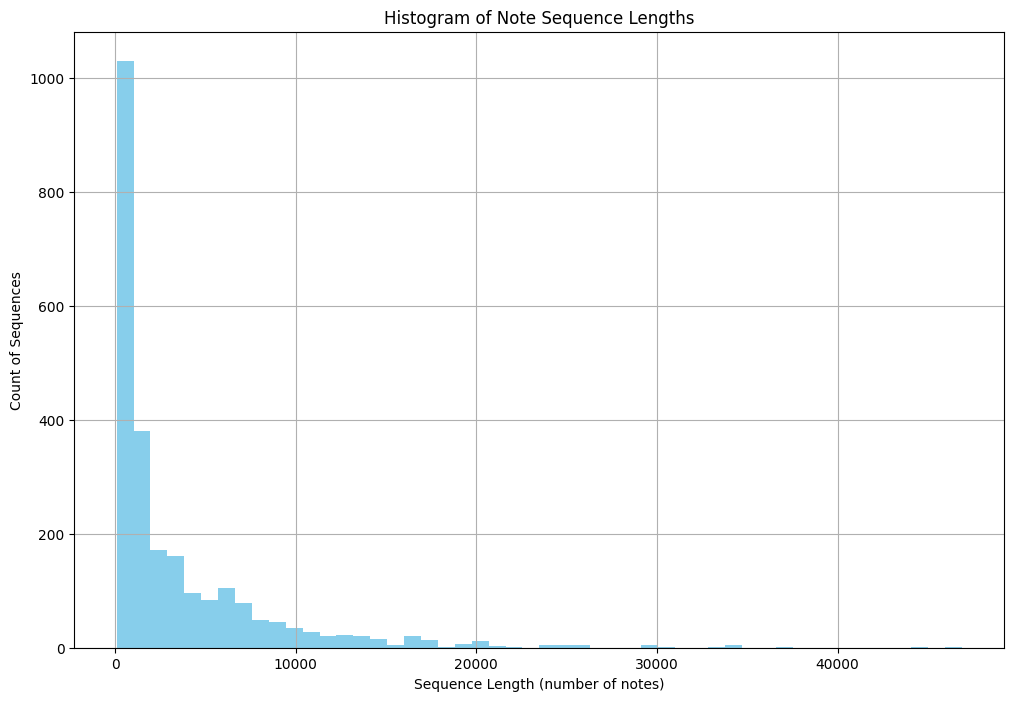

In [29]:
# Extract note sequences
note_seqs = features_df['note_seq']

# Keep only valid sequences (numpy arrays with shape (N, 4))
valid_note_seqs = [seq for seq in note_seqs if isinstance(seq, np.ndarray) and seq.ndim == 2 and seq.shape[1] == 4]

# Get the length (number of notes) for each sequence
seq_lengths = [seq.shape[0] for seq in valid_note_seqs]

# Compute statistics
mean_length = np.mean(seq_lengths) if seq_lengths else 0
median_length = np.median(seq_lengths) if seq_lengths else 0
min_length = np.min(seq_lengths) if seq_lengths else 0
max_length = np.max(seq_lengths) if seq_lengths else 0

print("Number of valid sequences:", len(seq_lengths))
print("Mean sequence length (number of notes):", mean_length)
print("Median sequence length", median_length)
print("Min sequence length:", min_length)
print("Max sequence length:", max_length)

# Ensure you are using the actual sequence length data you computed
seq_lengths = [seq.shape[0] for seq in valid_note_seqs]

# Plot histogram
plt.figure(figsize=(12, 8))
plt.hist(seq_lengths, bins=50, color='skyblue')
plt.title('Histogram of Note Sequence Lengths')
plt.xlabel('Sequence Length (number of notes)')
plt.ylabel('Count of Sequences')
plt.grid(True)
plt.show()

In [30]:
#Filter out lower bound outliers
lower_cutoff = 105 #Assign cutoff, anything below this length will be cut.

#Filter valid note sequences
valid_mask = [
    isinstance(seq, np.ndarray) and seq.ndim == 2 and seq.shape[1] == 4
    for seq in features_df['note_seq']
]
valid_features_df = features_df[valid_mask].copy()

#Mask sequences that are >= lower_cutoff
length_mask = valid_features_df['note_seq'].apply(lambda seq: seq.shape[0] >= lower_cutoff)

#Apply mask
filtered_features_df = valid_features_df[length_mask].copy()

#Update main reference
features_df = filtered_features_df.reset_index(drop=True)

#Print updated count
print("Number of sequences after filtering:", len(features_df))

Number of sequences after filtering: 2428


###Create train test split

In [31]:
#Create train, test split of feature_df
train_df, test_df = train_test_split(
    features_df,
    test_size=0.2,
    random_state=SEED,
    stratify=features_df['composer'] #Ensure each composer is split 80/20
)

In [32]:
#What is the counts of data in each folder, train, test, validation?
print(train_df.shape)
print(test_df.shape)

(1942, 24)
(486, 24)


###Normalize note sequences for better neural network processing

In [ ]:
'''
def normalize_note_seq(seq, min_pitch=21, max_pitch=108, max_velocity=127, max_duration=10.0):
    try:
        if not isinstance(seq, np.ndarray):
            seq = np.array(seq)
        if seq.ndim != 2 or seq.shape[1] < 4:
            # Skip or return original, or you could return np.zeros(...) or np.nan
            return seq
        seq = seq.astype(float)
        # Pitch (column 1)
        seq[:, 1] = (seq[:, 1] - min_pitch) / (max_pitch - min_pitch)
        seq[:, 1] = np.clip(seq[:, 1], 0, 1)
        # Velocity (column 3)
        seq[:, 3] = seq[:, 3] / max_velocity
        seq[:, 3] = np.clip(seq[:, 3], 0, 1)
        # Duration (column 2)
        seq[:, 2] = seq[:, 2] / max_duration
        seq[:, 2] = np.clip(seq[:, 2], 0, 1)
        return seq
    except Exception as e:
        # Optional: print(f"Skipping bad sequence: {e}")
        return seq

In [ ]:
##Execute Normalization (Turned off for better LSTM performance)
#train_df = train_df.copy()
#test_df = test_df.copy()

#train_df['note_seq'] = train_df['note_seq'].apply(normalize_note_seq)
#test_df['note_seq'] = test_df['note_seq'].apply(normalize_note_seq)

#Model Building

###LSTM - Model Building

In [33]:
def create_lstm_input_sequences(input_df, sequence_column='note_seq', target_length=500):
    """
    Prepares input sequences and corresponding labels for LSTM training using note sequence data.

    This function converts variable-length MIDI note sequences into fixed-length padded sequences,
    making them compatible with LSTM-based deep learning models for composer classification.
    """

    X_seq_data = [] # Initialize a list to store LSTM input sequences (padded/truncated note sequences).
    y_labels_seq = [] # Initialize a list to store label indices corresponding to composers.

    composer_idx_mapping = {name: idx for idx, name in enumerate(composers)} # Create a mapping of composer names to numeric indices for classification.

    for index, row in input_df.iterrows(): # Iterate over each MIDI file (row) in the input dataframe.

        # Extract the note sequence matrix from the specified column.
        # Each sequence has shape (N, 4), where N is the number of notes, and 4 represents:
        # [start_time, pitch, duration, velocity]
        note_sequence = row[sequence_column]      # shape (n_notes, 3)
        extra_features = np.array([row['tempo'], row['note_density']], dtype=np.float32)  # shape (2,) added to try and improve composer differentiation
        composer_label = row['composer']

        # Repeat the extra features to match sequence length
        extras_repeated = np.tile(extra_features, (note_sequence.shape[0], 1))  # shape (n_notes, 2)

        # Concatenate along the last axis (columns) -> shape (n_notes, 5)
        full_sequence = np.concatenate([note_sequence, extras_repeated], axis=1)

        EXPECTED_FEATURES = 6  # 4 note features + 2 global features
        if not isinstance(full_sequence, np.ndarray) or full_sequence.ndim != 2 or full_sequence.shape[1] != EXPECTED_FEATURES:
            continue

        # Handle variable sequence lengths by padding or truncating to `target_length`.
        # LSTM models require input sequences to have uniform length.
        if full_sequence.shape[0] < target_length:
            # If the sequence is too short, pad with zeros at the end.
            # Padding preserves sequence order while ensuring shape compatibility.
            padded_sequence = np.pad(full_sequence, ((0, target_length - full_sequence.shape[0]), (0, 0)))
        else:
            # If the sequence is too long, truncate to the first `target_length` steps.
            padded_sequence = full_sequence[:target_length]

        # Append the processed sequence to the input data list.
        X_seq_data.append(padded_sequence)

        # Append the corresponding composer label (as an integer index) to the label list.
        y_labels_seq.append(composer_idx_mapping[composer_label])

    # Convert the list of input sequences into a NumPy array.
    # Final shape: (number_of_samples, target_length, 4)
    X_seq_data = np.array(X_seq_data)

    # Convert labels into one-hot encoded format for classification.
    # Example: If there are 6 classes, label '1' becomes [0,1,0,0]
    y_labels_seq_onehot = to_categorical(y_labels_seq, num_classes=len(composers))

    # Return the LSTM input data (X) and the one-hot encoded labels (y).
    return X_seq_data, y_labels_seq_onehot

In [34]:

def build_simple_lstm_classifier(input_dimensions, num_output_classes):
    """
    Builds and returns a simple LSTM-based neural network classifier for sequence data.

    This model is used to classify composers based on note sequence data extracted from MIDI files.
    LSTMs are ideal for this task because they can capture temporal dependencies in sequential musical patterns.
    """

    # Initialize a Keras Sequential model.
    # This means the layers are stacked one after the other in a linear pipeline.
    lstm_net = models.Sequential()

    # Add an input layer to define the shape of the input sequences.
    # input_dimensions: (sequence_length, number_of_features) -> (500, 4) in this project.
    # Features include: start_time, pitch, duration, velocity.
    lstm_net.add(layers.Input(shape=input_dimensions))

    # Add a Long Short-Term Memory (LSTM) layer with 64 units.
    # First LSTM layer: must return sequences to pass to the next LSTM layer
    lstm_net.add(layers.LSTM(64))

    # Add a fully connected Dense layer with 64 neurons and ReLU activation.
    # This layer introduces non-linearity and helps the model learn complex decision boundaries
    # after processing the sequential data from the LSTM.
    lstm_net.add(layers.Dense(64, activation='relu'))

    #See if dropout enhances performance
    lstm_net.add(layers.Dropout(0.2))

    # Add the output Dense layer with 'num_output_classes' neurons (e.g., 4 composers).
    # Use softmax activation to output class probabilities (multi-class classification).
    lstm_net.add(layers.Dense(num_output_classes, activation='softmax'))


    # Compile the model:
    # - Optimizer: Adam (adaptive learning rate, good for deep learning tasks)
    # - Loss function: Categorical cross-entropy (because labels are one-hot encoded)
    # - Metrics: Track accuracy during training and evaluation.


    learning_rate = 0.001  # Learning rate
    optimizer = Adam(learning_rate=learning_rate)

    lstm_net.compile(
      optimizer=optimizer,
      loss='categorical_crossentropy',   #
      metrics=['accuracy']
    )

    # Return the constructed LSTM classifier model.
    return lstm_net

##LSTM - Model Training & Evaluation

In [35]:
print(" Preparing LSTM data...")

# Filter out rows with unexpected note_seq shapes before creating sequences
train_df_filtered = train_df[
    train_df['note_seq'].apply(lambda x: isinstance(x, np.ndarray) and x.ndim == 2 and x.shape[1] == 4)
].copy()
test_df_filtered = test_df[
    test_df['note_seq'].apply(lambda x: isinstance(x, np.ndarray) and x.ndim == 2 and x.shape[1] == 4)
].copy()


# Prepares sequence data for LSTM by extracting fixed-length note sequences.
# Sequences are padded or truncated to uniform length (500 steps here).
X_train_lstm, y_train_lstm = create_lstm_input_sequences(train_df_filtered, target_length=500)
X_test_lstm, y_test_lstm = create_lstm_input_sequences(test_df_filtered, target_length=500)

 Preparing LSTM data...


In [36]:
print(" Training LSTM model...")

# Define input shape for the LSTM model: (sequence_length, feature_dim), e.g., (500, 4)
input_shape_lstm = (X_train_lstm.shape[1], X_train_lstm.shape[2])

# Build an LSTM-based neural network for composer classification.
lstm_model_final = build_simple_lstm_classifier(input_shape_lstm, num_output_classes=len(composers))

# Define early stopping callback: monitors val_loss, stops if no improvement after e.g., ?? epochs
early_stop = EarlyStopping(
    monitor='val_loss',      # or 'val_accuracy'
    patience=50,              # number of epochs with no improvement
    restore_best_weights=True # restores weights from best epoch
)

# Train the LSTM model with early stopping
history = lstm_model_final.fit(
    X_train_lstm, y_train_lstm,
    epochs=500,
    batch_size=32,
    validation_split=0.2,
    verbose=1,
    callbacks=[early_stop],
)

 Training LSTM model...
Epoch 1/500
49/49 ━━━━━━━━━━━━━━━━━━━━ 10s 174ms/step - accuracy: 0.4729 - loss: 1.3059 - val_accuracy: 0.5630 - val_loss: 1.0574
Epoch 2/500
49/49 ━━━━━━━━━━━━━━━━━━━━ 8s 171ms/step - accuracy: 0.5332 - loss: 1.0750 - val_accuracy: 0.5810 - val_loss: 1.0194
Epoch 3/500
49/49 ━━━━━━━━━━━━━━━━━━━━ 8s 169ms/step - accuracy: 0.5483 - loss: 1.0468 - val_accuracy: 0.6298 - val_loss: 0.9796
Epoch 4/500
49/49 ━━━━━━━━━━━━━━━━━━━━ 8s 166ms/step - accuracy: 0.5933 - loss: 1.0058 - val_accuracy: 0.6221 - val_loss: 0.9717
Epoch 5/500
49/49 ━━━━━━━━━━━━━━━━━━━━ 8s 167ms/step - accuracy: 0.5900 - loss: 0.9949 - val_accuracy: 0.6195 - val_loss: 0.9854
Epoch 6/500
49/49 ━━━━━━━━━━━━━━━━━━━━ 8s 166ms/step - accuracy: 0.6130 - loss: 0.9758 - val_accuracy: 0.6272 - val_loss: 0.9539
Epoch 7/500
49/49 ━━━━━━━━━━━━━━━━━━━━ 8s 165ms/step - accuracy: 0.6131 - loss: 0.9407 - val_accuracy: 0.6401 - val_loss: 0.9535
Epoch 8/500
49/49 ━━━━━━━━━━━━━━━━━━━━ 8s 168ms/step - accuracy: 0.6420 

##TEMP - Notes on Run Performance:
1. 7.21 - 10:16 - With normalization, 300 epochs, 50 patience, .75 accuracy.

2. 7.21 - 11:13 - Without normalization, stopped at 200 epochs, patience 50, .92 accuracy.

3. 7.21 - 12:02 - Remove lower bound, without normalization, maxed at 155 epochs, patience at 40. (adjusted patience back to 50 before save to see what happens)

4. 7/26 - 9:00 - added code to ensure 80% of each composer was splite for train, and 20% for test. All else the same. .92+ on training accuracy.

##LSTM Evaluation

In [107]:
# Evaluate on test set using Keras
loss, accuracy = lstm_model_final.evaluate(X_test_lstm, y_test_lstm, verbose=1)

#Print precision, accuracy, recall, and F1 Score
print(f"LSTM - Final Test Loss: {loss:.4f}")
print(f"LSTM - Final Test Accuracy: {accuracy:.4f}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.8273 - loss: 0.5884
LSTM - Final Test Loss: 0.5812
LSTM - Final Test Accuracy: 0.8416


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step
              precision    recall  f1-score   support

        bach       0.91      0.94      0.93       246
      handel       0.71      0.79      0.75        87
      chopin       0.83      0.63      0.72        54
      mozart       0.79      0.76      0.77        99

    accuracy                           0.84       486
   macro avg       0.81      0.78      0.79       486
weighted avg       0.84      0.84      0.84       486



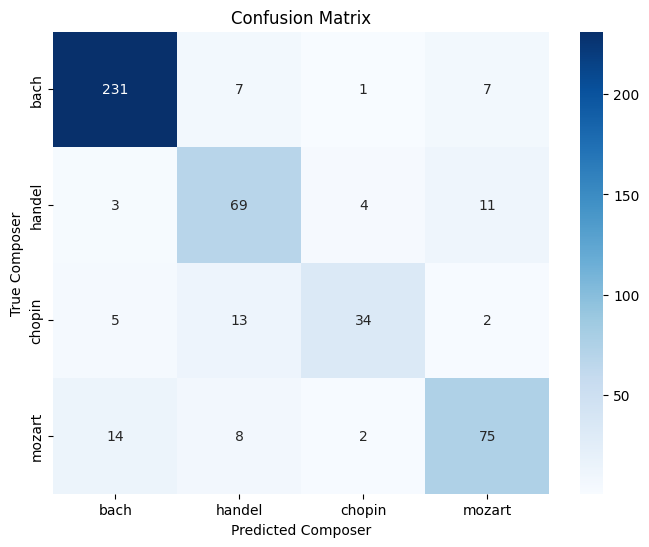

In [103]:
# Composer names/classes, in label order
class_names = ['bach', 'handel', 'chopin', 'mozart']  # Adapt as needed

# Evaluate the model and predict classes
# y_test: true labels (one-hot encoded or integer-encoded)
# model: your trained LSTM

# Get predicted probabilities
y_pred_proba = lstm_model_final.predict(X_test_lstm)

# Convert probabilities to predicted class indices
y_pred = np.argmax(y_pred_proba, axis=1)
y_true = np.argmax(y_test_lstm, axis=1)  # if y_test is one-hot; else use y_test directly

# Print classification report with composer names
print(classification_report(y_true, y_pred, target_names=class_names))

# Build and plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Composer')
plt.ylabel('True Composer')
plt.title('Confusion Matrix')
plt.show()

#CNN Code

In [55]:
TARGET_LENGTH = 500  # fixed length for your piano roll inputs

def pad_or_truncate_pianoroll(pianoroll, target_length=TARGET_LENGTH):
    """
    Pads with zeros or truncates the piano roll to the target length (time dimension).
    Assumes input piano_roll shape = (timesteps, pitches).
    """
    timesteps, pitches = pianoroll.shape
    if timesteps >= target_length:
        # Truncate to target_length
        return pianoroll[:target_length, :]
    else:
        # Pad with zeros to target_length
        padding = np.zeros((target_length - timesteps, pitches), dtype=pianoroll.dtype)
        return np.vstack([pianoroll, padding])

# Apply to your DataFrame column with loaded piano roll arrays (e.g., 'note_seq' or 'piano_roll' column)
features_df['piano_roll_fixed'] = features_df['note_seq'].dropna().apply(pad_or_truncate_pianoroll)

# Stack into array for CNN input
X_roll = np.stack(features_df.loc[features_df['piano_roll_fixed'].notna(), 'piano_roll_fixed'].values)

# Add channel dimension required by Conv2D (if not present)
if X_roll.ndim == 3:  # shape = (samples, timesteps=500, pitches)
    X_roll = X_roll[..., np.newaxis]  # becomes (samples, 500, pitches, 1)

print("Prepared piano roll shape for CNN:", X_roll.shape)
# Expected shape: (num_samples, 500, pitches, 1)

Prepared piano roll shape for CNN: (2428, 500, 4, 1)


In [77]:
# Only include rows with valid piano roll arrays
valid = features_df['piano_roll_fixed'].notna()

# Safely stack all arrays into a 3D/4D NumPy array
X_roll = np.stack(features_df.loc[valid, 'piano_roll_fixed'].values)
if X_roll.ndim == 3:
    X_roll = X_roll[..., np.newaxis]  # Add channels dim
print("X_roll shape:", X_roll.shape)  # E.g. (2428, 500, 4, 1)

X_roll shape: (2428, 500, 4, 1)


In [78]:
label_encoder = LabelEncoder()
y_int = label_encoder.fit_transform(features_df['composer'])
# Now y_int gives you label 0 for 'Bach', 1 for 'Beethoven', etc.

y_train_onehot = to_categorical(y_train)
y_val_onehot = to_categorical(y_val)

In [88]:
num_classes = len(np.unique(y_train))  # or your existing value

y_train = to_categorical(y_train, num_classes)
y_val = to_categorical(y_val, num_classes)

X_roll_train, X_roll_val, X_stats_train, X_stats_val, y_train, y_val = train_test_split(
    X_roll, X_stats, y_int, test_size=0.2, random_state=SEED, stratify=y_int
)

y_train shape after one-hot: (1942, 4)


In [89]:
print('Train counts:', np.bincount(y_train))
print('Val counts:', np.bincount(y_val))
print('Labels:', label_encoder.classes_)

Train counts: [984 345 216 397]
Val counts: [246  87  54  99]
Labels: ['Bach' 'Beethoven' 'Chopin' 'Mozart']


In [94]:
#Model Building (Hybrid CNN + MLP)
def build_hybrid_model(piano_roll_shape, stats_shape, num_classes):
    roll_input = Input(shape=piano_roll_shape, name='roll_input')
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(roll_input)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Flatten()(x)

    stats_input = Input(shape=(stats_shape,), name='stats_input')
    s = layers.Dense(64, activation='relu')(stats_input)

    merged = layers.concatenate([x, s])
    merged = layers.Dense(128, activation='relu')(merged)
    merged = layers.Dropout(0.4)(merged)
    output = layers.Dense(num_classes, activation='softmax')(merged)

    model = Model(inputs=[roll_input, stats_input], outputs=output)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Class Weights
def compute_class_weights(y_train):
    # If one-hot, convert to integer labels
    if y_train.ndim == 2 and y_train.shape[1] > 1:
        y_int = np.argmax(y_train, axis=1)
    else:
        y_int = y_train
    from sklearn.utils.class_weight import compute_class_weight
    weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_int), y=y_int)
    return dict(enumerate(weights))

#Training Wrapper
def train_hybrid_model(model, X_roll_train, X_stats_train, y_train,
                       X_roll_val, X_stats_val, y_val, epochs=20, batch_size=32):
    class_weights = compute_class_weights(y_train)
    callbacks = [
        EarlyStopping(patience=5, restore_best_weights=True),
        ReduceLROnPlateau(patience=3, factor=0.5)
    ]
    model.fit(
        {'roll_input': X_roll_train, 'stats_input': X_stats_train},
        y_train,
        validation_data=({'roll_input': X_roll_val, 'stats_input': X_stats_val}, y_val),
        epochs=epochs,
        batch_size=batch_size,
        class_weight=class_weights,
        callbacks=callbacks,
        verbose=1
    )
    return model

In [96]:
print(f"X_roll_train type: {type(X_roll_train)}")
print(f"X_roll_train shape: {X_roll_train.shape}")
print(f"X_roll_train ndim: {X_roll_train.ndim}")

print(f"X_stats_train type: {type(X_stats_train)}")
print(f"X_stats_train shape: {X_stats_train.shape}")
print(f"X_stats_train ndim: {X_stats_train.ndim}")

print("y_train shape:", y_train.shape)
print("y_train ndim:", y_train.ndim)
print("Unique values in y_train:", np.unique(y_train))

X_roll_train type: <class 'numpy.ndarray'>
X_roll_train shape: (1942, 500, 4, 1)
X_roll_train ndim: 4
X_stats_train type: <class 'numpy.ndarray'>
X_stats_train shape: (1942, 14)
X_stats_train ndim: 2
y_train shape: (1942,)
y_train ndim: 1
Unique values in y_train: [0 1 2 3]


In [95]:
#Model
model = build_hybrid_model(
    piano_roll_shape=X_roll_train.shape[1:],  # (500, 4, 1)
    stats_shape=X_stats_train.shape[1],       # 14
    num_classes=num_classes
)


#Train
train_hybrid_model(
    model, X_roll_train, X_stats_train, y_train,
    X_roll_val, X_stats_val, y_val
)

Epoch 1/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.3946 - loss: 16.6622 - val_accuracy: 0.6358 - val_loss: 0.9377 - learning_rate: 0.0010
Epoch 2/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.6614 - loss: 1.0101 - val_accuracy: 0.7284 - val_loss: 0.7709 - learning_rate: 0.0010
Epoch 3/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.7342 - loss: 0.7921 - val_accuracy: 0.7840 - val_loss: 0.6496 - learning_rate: 0.0010
Epoch 4/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.7821 - loss: 0.6537 - val_accuracy: 0.7984 - val_loss: 0.5917 - learning_rate: 0.0010
Epoch 5/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.8212 - loss: 0.5581 - val_accuracy: 0.8169 - val_loss: 0.5827 - learning_rate: 0.0010
Epoch 6/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.8276 - loss: 0.5211 - val_accuracy: 0.8251 - val_loss: 0.5594 - learning_rate: 0.0010
Epoch 7/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.8585 - loss: 0.4378 - val_ac

<Functional name=functional_8, built=True>

In [106]:
#Evaluate CNN Performance
test_loss, test_acc = model.evaluate(
    {'roll_input': X_roll_val, 'stats_input': X_stats_val}, y_val, verbose=0
)

#Print precision, accuracy, recall, and F1 Score
print(f"CNN - Final Test Loss: {test_loss:.4f}")
print(f"CNN - Final Test Accuracy: {test_acc:.4f}")

CNN - Final Test Loss: 0.4673
CNN - Final Test Accuracy: 0.8642


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
              precision    recall  f1-score   support

        Bach       0.94      0.90      0.92       246
   Beethoven       0.88      0.75      0.81        87
      Chopin       0.77      0.85      0.81        54
      Mozart       0.75      0.88      0.81        99

    accuracy                           0.86       486
   macro avg       0.83      0.85      0.84       486
weighted avg       0.87      0.86      0.87       486



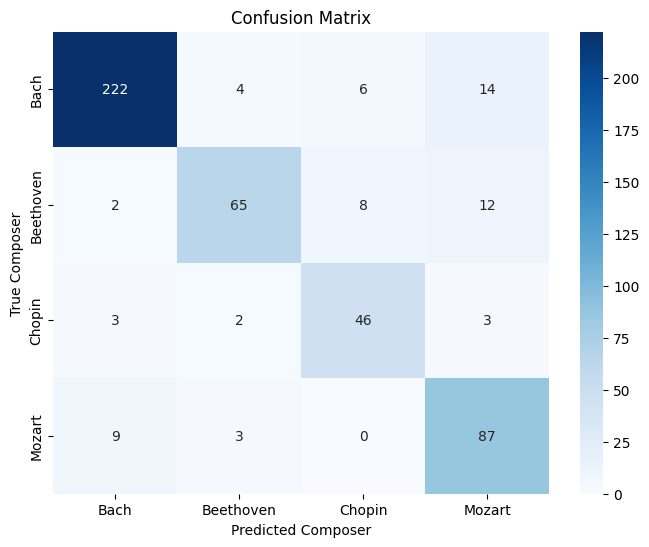

In [104]:
# Get predicted probabilities for CNN
y_pred_proba = model.predict([X_roll_val, X_stats_val])

# Convert probabilities to predicted class indices for CNN
y_pred = np.argmax(y_pred_proba, axis=1)
y_true = y_val  # if y_test is one-hot; else use y_test directly

# Print classification report with composer names for CNN
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))

# Build and plot confusion matrix for CNN results
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Composer')
plt.ylabel('True Composer')
plt.title('Confusion Matrix')
plt.show()

#Extra Code

In [ ]:
'''

# ----------------------------------------
# Imports and Configuration
# ----------------------------------------
import os
import numpy as np
import pandas as pd
import pretty_midi
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras import layers, models, Input, Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Constants
DATA_DIR = os.path.join('.', 'data')
COMPOSERS = ['Bach', 'Beethoven', 'Chopin', 'Mozart']
SUPPORTED_EXT = ('.mid', '.midi')

# ----------------------------------------
# Step 1: MIDI File Collection
# ----------------------------------------
def get_midi_files(data_dir, composers):
    all_paths = []
    for composer in composers:
        folder = os.path.join(data_dir, composer)
        files = [os.path.join(folder, f) for f in os.listdir(folder) if f.lower().endswith(SUPPORTED_EXT)]
        for file in files:
            all_paths.append((file, composer))
    return pd.DataFrame(all_paths, columns=['filepath', 'composer'])

# ----------------------------------------
# Step 2: MIDI Statistics Extraction
# ----------------------------------------
def extract_note_statistics(file_path):
    midi_data = pretty_midi.PrettyMIDI(file_path)
    pitches = [note.pitch for instr in midi_data.instruments for note in instr.notes]
    velocities = [note.velocity for instr in midi_data.instruments for note in instr.notes]
    _, tempos = midi_data.get_tempo_changes()

    return {
        'pitch_std': np.std(pitches),
        'pitch_min': np.min(pitches),
        'pitch_max': np.max(pitches),
        'velocity_mean': np.mean(velocities),
        'velocity_std': np.std(velocities),
        'velocity_min': np.min(velocities),
        'velocity_max': np.max(velocities),
        'tempo_mean': np.mean(tempos),
        'tempo_min': np.min(tempos),
        'tempo_max': np.max(tempos),
    }

def extract_statistics_dataframe(df):
    stats = []
    for _, row in df.iterrows():
        try:
            feats = extract_note_statistics(row['filepath'])
            feats['composer'] = row['composer']
            stats.append(feats)
        except Exception as e:
            print(f"Error in stats for {row['filepath']}: {e}")
    return pd.DataFrame(stats)

# ----------------------------------------
# Step 3: Multichannel Piano Roll
# ----------------------------------------
def process_multichannel_midi(file_path, fs=8, max_length=150):
    midi = pretty_midi.PrettyMIDI(file_path)
    piano_roll = midi.get_piano_roll(fs=fs)
    binary_roll = (piano_roll > 0).astype(np.float32)
    velocity_roll = (piano_roll / 127.0).astype(np.float32)

    instrument_rolls = [instr.get_piano_roll(fs=fs) for instr in midi.instruments]
    max_len = max((r.shape[1] for r in instrument_rolls), default=0)
    inst_combined = np.zeros((128, max_len))
    for roll in instrument_rolls:
        roll = np.pad(roll, ((0, 0), (0, max_len - roll.shape[1])), mode='constant')
        inst_combined += (roll > 0).astype(np.float32)
    inst_combined = (inst_combined / inst_combined.max()).astype(np.float32) if inst_combined.max() > 0 else inst_combined

    expressive_roll = np.zeros((128, max_len))
    for instr in midi.instruments:
        for note in instr.notes:
            start = int(note.start * fs)
            end = int(note.end * fs)
            expressive_roll[note.pitch, start:end] = 1
    expressive_roll = expressive_roll.astype(np.float32)

    def fix_length(arr): return np.pad(arr, ((0, 0), (0, max(0, max_length - arr.shape[1]))), mode='constant')[:, :max_length]
    binary_roll = fix_length(binary_roll)
    velocity_roll = fix_length(velocity_roll)
    inst_combined = fix_length(inst_combined)
    expressive_roll = fix_length(expressive_roll)

    return np.stack([binary_roll, velocity_roll, inst_combined, expressive_roll], axis=-1)

# ----------------------------------------
# Step 4: Dataset Creation
# ----------------------------------------
def create_combined_dataset(df, fs=8, max_length=150):
    X_roll, X_stats, y = [], [], []
    label_map = {name: idx for idx, name in enumerate(COMPOSERS)}
    for _, row in df.iterrows():
        try:
            roll = process_multichannel_midi(row['filepath'], fs=fs, max_length=max_length)
            stats = extract_note_statistics(row['filepath'])
            X_roll.append(roll)
            X_stats.append(list(stats.values()))
            y.append(label_map[row['composer']])
        except Exception as e:
            print(f"Error processing {row['filepath']}: {e}")
    return (np.array(X_roll).astype(np.float32),
            np.array(X_stats).astype(np.float32),
            to_categorical(np.array(y), num_classes=len(COMPOSERS)))

# ----------------------------------------
# Step 5: Split Dataset
# ----------------------------------------
def stratified_split_dataframe(df, label_col='composer', test_size=0.2, val_size=0.1, random_state=42):
    label_map = {label: idx for idx, label in enumerate(sorted(df[label_col].unique()))}
    y = df[label_col].map(label_map).values
    sss1 = StratifiedShuffleSplit(n_splits=1, test_size=(test_size + val_size), random_state=random_state)
    for train_idx, temp_idx in sss1.split(df, y):
        train_df, temp_df = df.iloc[train_idx], df.iloc[temp_idx]
    sss2 = StratifiedShuffleSplit(n_splits=1, test_size=test_size / (test_size + val_size), random_state=random_state)
    y_temp = temp_df[label_col].map(label_map).values
    for val_idx, test_idx in sss2.split(temp_df, y_temp):
        val_df, test_df = temp_df.iloc[val_idx], temp_df.iloc[test_idx]
    return train_df.reset_index(drop=True), val_df.reset_index(drop=True), test_df.reset_index(drop=True)

# ----------------------------------------
# Step 6: Model Building (Hybrid CNN + MLP)
# ----------------------------------------
def build_hybrid_model(piano_roll_shape, stats_shape, num_classes):
    roll_input = Input(shape=piano_roll_shape, name='roll_input')
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(roll_input)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Flatten()(x)

    stats_input = Input(shape=(stats_shape,), name='stats_input')
    s = layers.Dense(64, activation='relu')(stats_input)

    merged = layers.concatenate([x, s])
    merged = layers.Dense(128, activation='relu')(merged)
    merged = layers.Dropout(0.4)(merged)
    output = layers.Dense(num_classes, activation='softmax')(merged)

    model = Model(inputs=[roll_input, stats_input], outputs=output)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# ----------------------------------------
# Step 7: Class Weights
# ----------------------------------------
def compute_class_weights(y_train_onehot):
    y_int = np.argmax(y_train_onehot, axis=1)
    weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_int), y=y_int)
    return dict(enumerate(weights))

# ----------------------------------------
# Step 8: Training Wrapper
# ----------------------------------------
def train_hybrid_model(model, X_roll_train, X_stats_train, y_train,
                       X_roll_val, X_stats_val, y_val, epochs=20, batch_size=32):
    class_weights = compute_class_weights(y_train)
    callbacks = [
        EarlyStopping(patience=5, restore_best_weights=True),
        ReduceLROnPlateau(patience=3, factor=0.5)
    ]
    model.fit(
        {'roll_input': X_roll_train, 'stats_input': X_stats_train},
        y_train,
        validation_data=({'roll_input': X_roll_val, 'stats_input': X_stats_val}, y_val),
        epochs=epochs,
        batch_size=batch_size,
        class_weight=class_weights,
        callbacks=callbacks,
        verbose=1
    )
    return model


# ----------------------------------------
# 1. Load MIDI File Paths
# ----------------------------------------
df = get_midi_files(DATA_DIR, COMPOSERS)
df = df[df['filepath'].apply(os.path.exists)]  # Just to be safe
df = df.reset_index(drop=True)

# ----------------------------------------
# 2. Split into Train/Val/Test
# ----------------------------------------
train_df, val_df, test_df = stratified_split_dataframe(df)

# ----------------------------------------
# 3. Extract Features: Multichannel Piano Roll + Statistics
# ----------------------------------------
print("Extracting training data...")
X_train_roll, X_train_stats, y_train = create_combined_dataset(train_df)
print("Extracting validation data...")
X_val_roll, X_val_stats, y_val = create_combined_dataset(val_df)
print("Extracting test data...")
X_test_roll, X_test_stats, y_test = create_combined_dataset(test_df)

# ----------------------------------------
# 4. Build Hybrid Model
# ----------------------------------------
input_shape_roll = X_train_roll.shape[1:]    # (128, 150, 4)
input_shape_stats = X_train_stats.shape[1]   # e.g., 10

model = build_hybrid_model(input_shape_roll, input_shape_stats, num_classes=len(COMPOSERS))

# ----------------------------------------
# 5. Train the Model
# ----------------------------------------
trained_model = train_hybrid_model(model,
                                   X_train_roll, X_train_stats, y_train,
                                   X_val_roll, X_val_stats, y_val)

# ----------------------------------------
# 6. Evaluate the Model (optional)
# ----------------------------------------
test_loss, test_acc = trained_model.evaluate(
    {'roll_input': X_test_roll, 'stats_input': X_test_stats}, y_test, verbose=0
)
print(f"✅ Final Test Accuracy: {test_acc:.2%}")
Extracting training data...
C:\Users\atul1\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\pretty_midi\pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(
Extracting validation data...
Error processing .\data\Beethoven\Anhang 14-3.mid: Could not decode key with 3 flats and mode 255
Extracting test data...
Error processing .\data\Mozart\K281 Piano Sonata n03 3mov.mid: Could not decode key with 2 flats and mode 2
Epoch 1/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step - accuracy: 0.3167 - loss: 2.5605 - val_accuracy: 0.5644 - val_loss: 1.0759 - learning_rate: 0.0010
Epoch 2/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - accuracy: 0.5591 - loss: 1.2815 - val_accuracy: 0.6380 - val_loss: 0.9917 - learning_rate: 0.0010
Epoch 3/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - accuracy: 0.6084 - loss: 1.1998 - val_accuracy: 0.6933 - val_loss: 0.8412 - learning_rate: 0.0010
Epoch 4/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - accuracy: 0.6603 - loss: 1.1045 - val_accuracy: 0.7117 - val_loss: 0.9162 - learning_rate: 0.0010
Epoch 5/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - accuracy: 0.6833 - loss: 0.9558 - val_accuracy: 0.7546 - val_loss: 0.7460 - learning_rate: 0.0010
Epoch 6/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - accuracy: 0.7374 - loss: 0.7991 - val_accuracy: 0.7669 - val_loss: 0.6070 - learning_rate: 0.0010
Epoch 7/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - accuracy: 0.7582 - loss: 0.7056 - val_accuracy: 0.7914 - val_loss: 0.5305 - learning_rate: 0.0010
Epoch 8/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - accuracy: 0.8283 - loss: 0.5807 - val_accuracy: 0.7791 - val_loss: 0.5956 - learning_rate: 0.0010
Epoch 9/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - accuracy: 0.8528 - loss: 0.4517 - val_accuracy: 0.7669 - val_loss: 0.5669 - learning_rate: 0.0010
Epoch 10/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 0.8861 - loss: 0.3278 - val_accuracy: 0.7975 - val_loss: 0.5366 - learning_rate: 0.0010
Epoch 11/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 6s 148ms/step - accuracy: 0.9085 - loss: 0.2560 - val_accuracy: 0.7791 - val_loss: 0.5666 - learning_rate: 5.0000e-04
Epoch 12/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 149ms/step - accuracy: 0.9259 - loss: 0.2786 - val_accuracy: 0.8282 - val_loss: 0.5531 - learning_rate: 5.0000e-04
✅ Final Test Accuracy: 80.43%

#Model Optimization

Techniques for optimization:

1. Data Handling
2. Hyperparameter Tuning
3.